In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


In [15]:
data_transform = transforms.Compose([
    # transforms.RandomResizedCrop(500), make 200x200 # normalise values to [0,1], rescaling
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

In [16]:

data_dir = "data/images/"
train_dataset = datasets.ImageFolder(root=data_dir + "training", transform=data_transform) # make val set
test_dataset = datasets.ImageFolder(root=data_dir + "testing", transform=data_transform)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

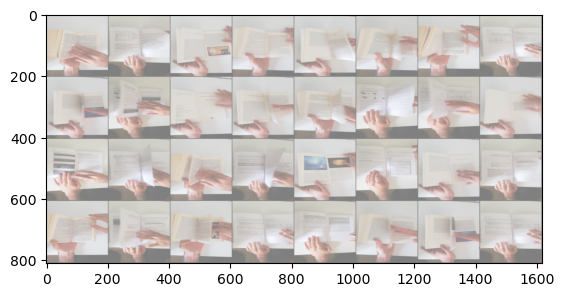

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

In [18]:
inputs, classes = next(iter(trainloader))

In [19]:
inputs.shape

torch.Size([32, 3, 200, 200])

In [20]:
inputs

tensor([[[[0.6353, 0.6314, 0.6314,  ..., 0.3451, 0.3529, 0.3608],
          [0.6314, 0.6275, 0.6275,  ..., 0.2667, 0.2667, 0.2627],
          [0.6275, 0.6235, 0.6235,  ..., 0.3216, 0.3020, 0.2824],
          ...,
          [0.0157, 0.0118, 0.0118,  ..., 0.1686, 0.1804, 0.1922],
          [0.0157, 0.0118, 0.0118,  ..., 0.1882, 0.1961, 0.1961],
          [0.0196, 0.0157, 0.0157,  ..., 0.2000, 0.2078, 0.2039]],

         [[0.6392, 0.6353, 0.6353,  ..., 0.3569, 0.3765, 0.3961],
          [0.6353, 0.6314, 0.6314,  ..., 0.2706, 0.2745, 0.2824],
          [0.6314, 0.6275, 0.6275,  ..., 0.3098, 0.2941, 0.2824],
          ...,
          [0.0078, 0.0118, 0.0118,  ..., 0.0353, 0.0353, 0.0353],
          [0.0078, 0.0118, 0.0118,  ..., 0.0353, 0.0353, 0.0353],
          [0.0118, 0.0157, 0.0157,  ..., 0.0353, 0.0392, 0.0392]],

         [[0.5843, 0.5725, 0.5647,  ..., 0.3020, 0.3020, 0.2980],
          [0.5765, 0.5686, 0.5647,  ..., 0.2275, 0.2275, 0.2275],
          [0.5686, 0.5647, 0.5647,  ..., 0

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 47 * 47, 120)  # Adjusted input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 0:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,    21] loss: 0.007
[1,    41] loss: 0.007
[1,    61] loss: 0.007
[2,     1] loss: 0.000
[2,    21] loss: 0.007
[2,    41] loss: 0.007
[2,    61] loss: 0.007
[3,     1] loss: 0.000
[3,    21] loss: 0.007
[3,    41] loss: 0.007
[3,    61] loss: 0.007
[4,     1] loss: 0.000
[4,    21] loss: 0.007
[4,    41] loss: 0.006
[4,    61] loss: 0.007
[5,     1] loss: 0.000
[5,    21] loss: 0.006
[5,    41] loss: 0.006
[5,    61] loss: 0.006
Finished Training


In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


net.eval()  # Set the net to evaluation mode

# Variables to store true labels and predictions
all_preds = []
all_labels = []

# Evaluate the net
with torch.no_grad():  # Disable gradient computation
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6650
Precision: 0.7623
Recall: 0.6650
F1 Score: 0.6258


In [ ]:
# confusion matrix
# look at +ve -ve class performance
# add part 2 sequences
# use validation set